# Getting started with DoWhy: A simple example
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and estimate the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.

First, let us add the required path for Python to find the DoWhy code and load all required packages.

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

Let's check the python version. 

In [2]:
print(sys.version)

3.6.6 (default, Sep  3 2018, 20:31:24) 
[GCC 5.4.0 20160609]


In [3]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [4]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=10000, 
        treatment_is_binary=True,
        num_discrete_common_causes=1)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0        W1        W2        W3 W4     v0  \
0  1.418641  0.0  0.251127  0.237823  1.294957 -2.197657  0.671354  1   True   
1  0.050088  0.0  0.041706 -1.199278  3.143332 -1.738985 -2.766051  1  False   
2 -0.480051  0.0  0.974275 -1.957273 -0.065116  0.175567 -1.829176  1   True   
3  0.338169  1.0  0.727792 -0.245409  0.099252  0.998839 -0.870295  0   True   
4 -1.026205  0.0  0.983040 -0.147827  1.538178  0.441017  0.343857  2   True   

           y  
0  19.477585  
1  -5.857091  
2   2.179680  
3   7.307447  
4  15.688496  
digraph { U[label="Unobserved Confounders"]; U->y;v0->y; U->v0;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"]

Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Interface 1 (recommended): Input causal graph

We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

In [5]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


In [6]:
model.view_model()

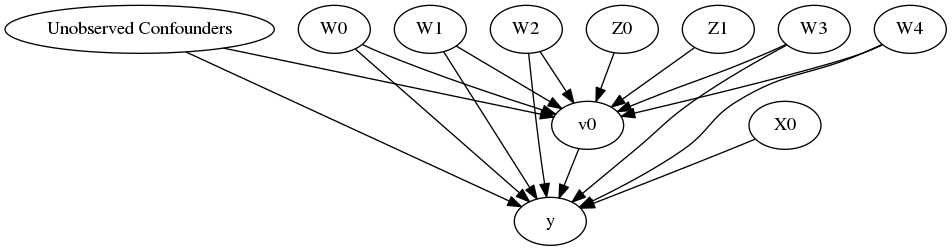

In [7]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify 
the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

**DoWhy philosophy: Keep identification and estimation separate**

Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step.
It is important to understand that these are orthogonal steps.

* Identification

In [8]:
identified_estimand = model.identify_effect()
print(identified_estimand)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1
Estimand expression:
  d                                 
─────(Expectation(y|W1,W2,W3,W0,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,W4,U) = P(y|v0,W1,W2,W3,W0,W4)

### Estimand : 2
Estimand name: backdoor2 (Default)
Estimand expression:
  d                                    
─────(Expectation(y|W1,W2,W3,W0,W4,X0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,W4,X0,U) = P(y|v0,W1,W2,W3,W0,W4,X0)

### Estimand : 3
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)



If you want to disable the warning for ignoring unobserved confounders, you can add a parameter flag ( *proceed\_when\_unidentifiable* ). The same parameter can also be added when instantiating the CausalModel object. 

In [9]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1
Estimand expression:
  d                                 
─────(Expectation(y|W1,W2,W3,W0,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,W4,U) = P(y|v0,W1,W2,W3,W0,W4)

### Estimand : 2
Estimand name: backdoor2 (Default)
Estimand expression:
  d                                    
─────(Expectation(y|W1,W2,W3,W0,W4,X0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,W4,X0,U) = P(y|v0,W1,W2,W3,W0,W4,X0)

### Estimand : 3
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)



* Estimation

In [10]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W2+W3+W0+W4+X0
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W1+W2+W3+W0+W4+X0
Target units: ate

## Estimate
Mean value: 8.937706276657458

Causal Estimate is 8.937706276657458


You can input additional parameters to the estimate_effect method. For instance, to estimate the effect on any subset of the units, you can specify the "target_units" parameter which can be a string ("ate", "att", or "atc"), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. You can also specify "effect modifiers" to estimate heterogeneous effects across these variables. See `help(CausalModel.estimate_effect)`. 

In [11]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W2+W3+W0+W4+X0
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W1+W2+W3+W0+W4+X0
Target units: atc

## Estimate
Mean value: 8.98008676434637

Causal Estimate is 8.98008676434637


## Interface 2: Specify common causes and instruments

In [12]:
# Without graph                                       
model= CausalModel(                             
        data=df,                                      
        treatment=data["treatment_name"],             
        outcome=data["outcome_name"],                 
        common_causes=data["common_causes_names"],
        effect_modifiers=data["effect_modifier_names"])                         

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


In [13]:
model.view_model()

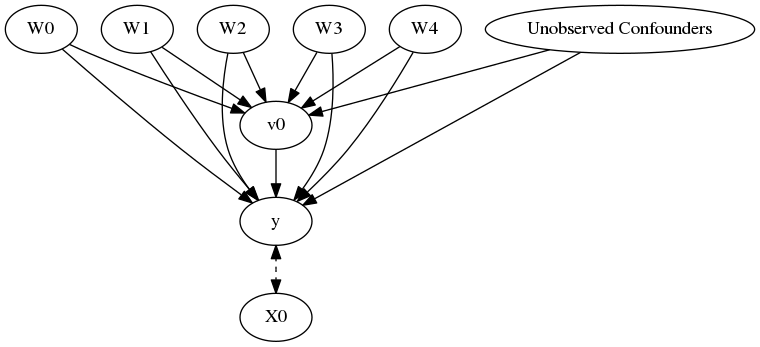

In [14]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get the same causal graph. Now identification and estimation is done as before.

In [15]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)                         

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


* Estimation

In [16]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")         
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W2+W3+W0+W1+W4
Target units: ate

## Estimate
Mean value: 9.124260741049653

Causal Estimate is 9.124260741049653


## Refuting the estimate

Let us now look at ways of refuting the estimate obtained.

### Adding a random common cause variable

In [17]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4+w_random
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Refute: Add a Random Common Cause
Estimated effect:9.124260741049653
New effect:9.13487620983324



### Adding an unobserved common cause variable

In [18]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Refute: Add an Unobserved Common Cause
Estimated effect:9.124260741049653
New effect:8.129085846396725



### Replacing treatment with a random (placebo) variable

In [19]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stra

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Making use of Bootstrap as we have more than 100 examples.
                 Note: The greater the number of examples, the more accurate are the confidence estimates


Refute: Use a Placebo Treatment
Estimated effect:9.124260741049653
New effect:-0.010832019791737903
p value:0.48



### Removing a random subset of the data

In [20]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.9 simulated datasets of size 9000.0 each
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estima

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6

INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vec

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6

Refute: Use a subset of data
Estimated effect:9.124260741049653
New effect:9.090515505813006
p value:0.37



As you can see, the propensity score stratification estimator is reasonably robust to refutations.
For reproducibility, you can add a parameter "random_seed" to any refutation method, as shown below.

In [21]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.9 simulated datasets of size 9000.0 each
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estima

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6

INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vec

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4
/home/amit/python-virtual-envs/env3.6/lib/python3.6

Refute: Use a subset of data
Estimated effect:9.124260741049653
New effect:9.084368615909547
p value:0.28

